# Image Object Detection: Multi-Class Convolutional Neural Network

## Notebook Goals
- use a pre-built set of images from the web
- build & experiment with machine-learning models
- build a multi(_10_)-classification CNN 
- Analyze Model performance
- fit a model several times and review the impact: increased accuracy?!

## Building A CNN
- familiarize with the data
- pre-process the data
- decide on model parameters
- create & fit the model
- evaluate model performance
- repeat previous 3 steps (parameters, create, fit, evaluate) to best performance

## Imports

In [1]:
import tensorflow as tf
import zipfile
import os
import pathlib
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

## Beware overfitting
Overfitting can happen when...
- too "large" a number of convolutional layers is present
- too "large" a number of convolutional filters is present
- **the "shape" of the accuracy-over-epochs curve** has changed from going up to flat &/or going down
- **the "shape" of the validation-loss-over-epochs curve** has changed from going down to either "flattening out" or even going up
- a "large" gap between training & validation curves of the same metric

### Preventing Overfitting: Regularization
- use more data
- simplify the model
- use data augmentation
- use transfer learning

## Get Data

In [2]:
# FOOD images!
# based on a HUGE "food101" dataset from kaggle
# https://www.kaggle.com/datasets/dansbecker/food-101
# https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 

fileName = "10_food_classes_all_data"
# Unzip the downloaded file
zip_ref = zipfile.ZipFile(fileName + '.zip', "r")
zip_ref.extractall()
zip_ref.close()

--2024-06-22 17:04:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.165.155, 142.250.65.187, 142.250.65.251, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.165.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  19.4MB/s    in 29s     

2024-06-22 17:04:33 (16.8 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



### Inspect

In [3]:
# Walk through 10_food_classes directory and list number of files
for dirpath, dirnames, filenames in os.walk(fileName):
    print(f'walk:   {dirpath.split("/")[-1].upper()}')
    if(len(dirnames) > 0):
        print(f'  dirs:     {len(dirnames)}')
    if(len(filenames) > 0):
        print(f'  images:     {len(filenames)}')
    # print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk:   10_FOOD_CLASSES_ALL_DATA
  dirs:     2
walk:   TEST
  dirs:     10
walk:   ICE_CREAM
  images:     250
walk:   CHICKEN_CURRY
  images:     250
walk:   STEAK
  images:     250
walk:   SUSHI
  images:     250
walk:   CHICKEN_WINGS
  images:     250
walk:   GRILLED_SALMON
  images:     250
walk:   HAMBURGER
  images:     250
walk:   PIZZA
  images:     250
walk:   RAMEN
  images:     250
walk:   FRIED_RICE
  images:     250
walk:   TRAIN
  dirs:     10
walk:   ICE_CREAM
  images:     750
walk:   CHICKEN_CURRY
  images:     750
walk:   STEAK
  images:     750
walk:   SUSHI
  images:     750
walk:   CHICKEN_WINGS
  images:     750
walk:   GRILLED_SALMON
  images:     750
walk:   HAMBURGER
  images:     750
walk:   PIZZA
  images:     750
walk:   RAMEN
  images:     750
walk:   FRIED_RICE
  images:     750


### Create Variables

In [4]:
# 
# training & testing directory paths
# 
training_dir_path = fileName + '/train/'
testing_dir_path = fileName + '/test/'
trainingPath = pathlib.Path(training_dir_path)

# 
# classification names in arr
# 
class_names = np.array(sorted([item.name for item in trainingPath.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


### Preview Image(s)

In [5]:
def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (512, 512, 3)


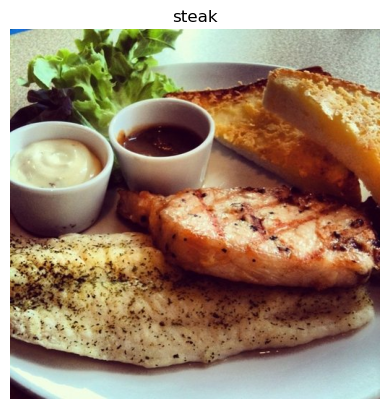

In [6]:
img = view_random_image(target_dir=training_dir_path,
                        target_class=random.choice(class_names)) # get a random class name

### Data Cleanup
- convert training & testing images to tensors
- **SHUFFLE** the images in each directory (training & testing) to remove any patterns learned based on order

In [7]:
# 
# create data-generators 
#   which include re-scaling
# 
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# batchSize = 32
# i get Allocation of 63083520 exceeds 10% of free system memory.
batchSize = 16

# 
# Load images into variables:
#   rescale the output sizes to 244x244
#   store in "batches" of 32 to minimize images-stored-in-memory during training
#   shuffle the data
#   
# 
training_data = train_datagen.flow_from_directory(training_dir_path,
                                               target_size=(224, 224),
                                               batch_size=batchSize,
                                               class_mode='categorical',
                                               shuffle=True)

testing_data = train_datagen.flow_from_directory(testing_dir_path,
                                              target_size=(224, 224),
                                              batch_size=batchSize,
                                              class_mode='categorical',
                                              shuffle=True)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Model: Baseline

In [8]:
# 
# data-driven output unit-count
# 
outputUnitCount = len(class_names)

In [9]:
# 
# Create
# 
# based on the TinyVGG model
# https://github.com/poloclub/cnn-explainer/blob/master/tiny-vgg/tiny-vgg.py#L179
baseline = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(outputUnitCount, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

In [10]:
# 
# Compile
# 
baseline.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [11]:
# 
# FIT
# 
baselineHistory = baseline.fit(training_data,
                        epochs=5,
                        steps_per_epoch=len(training_data),
                        validation_data=testing_data,
                        validation_steps=len(testing_data))

Epoch 1/5
469/469 [==============================] - 262s 557ms/step - loss: 2.1328 - accuracy: 0.2223 - val_loss: 2.0056 - val_accuracy: 0.2924
Epoch 2/5
469/469 [==============================] - 265s 565ms/step - loss: 1.8059 - accuracy: 0.3884 - val_loss: 1.7973 - val_accuracy: 0.3712
Epoch 3/5
469/469 [==============================] - 226s 481ms/step - loss: 1.1496 - accuracy: 0.6223 - val_loss: 2.0732 - val_accuracy: 0.3324
Epoch 4/5
469/469 [==============================] - 226s 482ms/step - loss: 0.3768 - accuracy: 0.8884 - val_loss: 3.2622 - val_accuracy: 0.3088
Epoch 5/5
469/469 [==============================] - 223s 476ms/step - loss: 0.0805 - accuracy: 0.9801 - val_loss: 4.7947 - val_accuracy: 0.2824


### Inspect Results

#### Summary

In [12]:
baseline.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

#### Visualize Loss & Accuracy

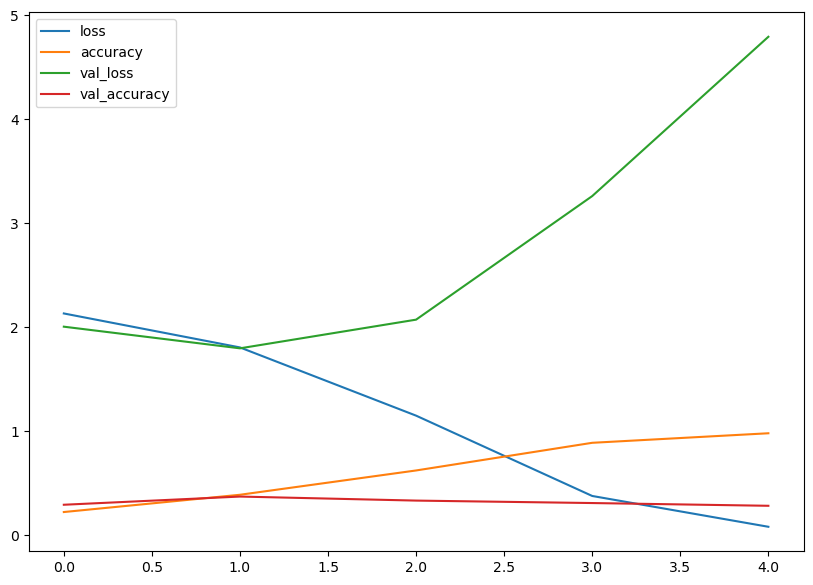

In [13]:
pd.DataFrame(baselineHistory.history).plot(figsize=(10, 7));

In [90]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  chartW = 12
  chartH = 3
      # history.history
    loss = history['history']['loss']
      # history.history
    val_loss = history['history']['val_loss']

      # history.history
    accuracy = history['history']['accuracy']
      # history.history
    val_accuracy = history['history']['val_accuracy']

      # history.history
    epochCount = range(len(history['history']['loss']))

  plt.figure(figsize=(chartW, chartH))
    
  plt.subplot(1, 2, 1)
  plt.ylim(bottom=0) #ymin is your value
  plt.ylim(top=3) #ymin is your value
  # Plot loss
  plt.plot(epochCount, loss, label='training_loss')
  plt.plot(epochCount, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  # plt.figure(figsize=(chartW, chartH))
  plt.subplot(1, 2, 2)
  plt.ylim(bottom=0) #ymin is your value
  plt.ylim(top=3) #ymin is your value
  plt.plot(epochCount, accuracy, label='training_accuracy')
  plt.plot(epochCount, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

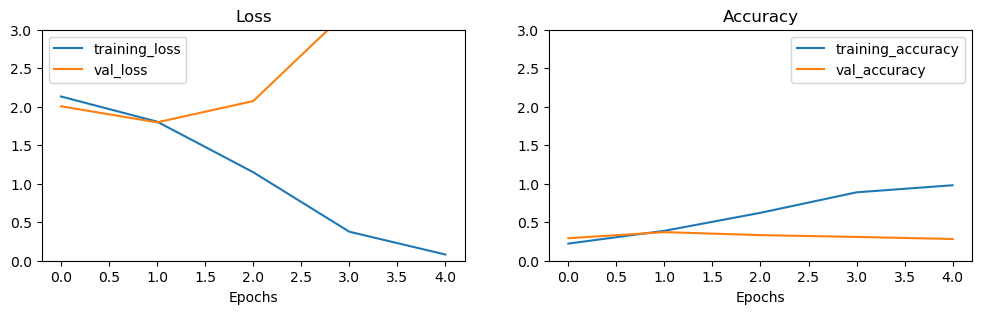

In [66]:
plot_loss_curves(baselineHistory)

#### Analysis Notes
- the `val_accuracy`, or "validation accuracy" looks to be `29`: not very good
- the `val_loss`, or "validation loss", goes up from 2 to 4: this is usually a sign of over-fitting: not good

#### Adjust Model: Change Layers
Try `Conv2d` then `MaxPool2D` alternating?! see if that helps?!

## Model II: Change Layers
Less layers

In [16]:
m2 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(outputUnitCount, activation='softmax') # changed to have 10 neurons (same as number of classes) and 'softmax' activation
])

In [17]:
# 
# Compile
# 
m2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [18]:
# 
# FIT
# 
m2History = m2.fit(training_data,
                        epochs=5,
                        steps_per_epoch=len(training_data),
                        validation_data=testing_data,
                        validation_steps=len(testing_data))

Epoch 1/5
469/469 [==============================] - 101s 214ms/step - loss: 2.1173 - accuracy: 0.2311 - val_loss: 1.9689 - val_accuracy: 0.2872
Epoch 2/5
469/469 [==============================] - 116s 248ms/step - loss: 1.8654 - accuracy: 0.3603 - val_loss: 1.8445 - val_accuracy: 0.3464
Epoch 3/5
469/469 [==============================] - 101s 216ms/step - loss: 1.6447 - accuracy: 0.4432 - val_loss: 1.8629 - val_accuracy: 0.3476
Epoch 4/5
469/469 [==============================] - 100s 214ms/step - loss: 1.4254 - accuracy: 0.5163 - val_loss: 1.9406 - val_accuracy: 0.3652
Epoch 5/5
469/469 [==============================] - 120s 255ms/step - loss: 1.1914 - accuracy: 0.6061 - val_loss: 2.0862 - val_accuracy: 0.3496


### Inspect Results
#### Summary

In [19]:
m2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 26, 26, 10)       

#### Visualize Loss & Accuracy

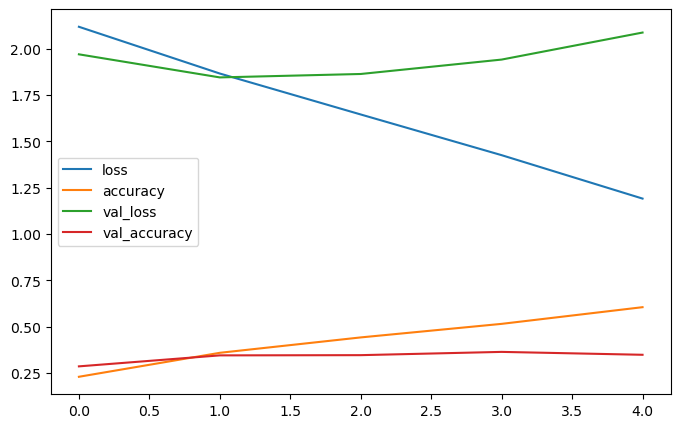

In [20]:
pd.DataFrame(m2History.history).plot(figsize=(8, 5));

In [93]:
plot_loss_curves(m2History)

TypeError: 'History' object is not subscriptable

#### Adjust Model: Data Augmentation
## Model III: Data Augmentation
### Augment Data

In [43]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # note: this is an int not a float
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

# 
# will re-use "train_datagen" from above
# 

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)

# Import data and augment the data from training directory
print("Augmented training images:")
train_data_augmented = train_datagen_augmented.flow_from_directory(training_dir_path,
                                                                  target_size=(224, 224),
                                                                  batch_size=32,
                                                                  class_mode='categorical',
                                                                  shuffle=True,
                                                                  seed=42)
# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(training_dir_path,
                                               target_size=(224, 224),
                                               batch_size=batchSize,
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=42)

print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(testing_dir_path,
                                             target_size=(224, 224),
                                             batch_size=batchSize,
                                             class_mode='categorical',
                                             shuffle=True,
                                             seed=42)

Augmented training images:
Found 7500 images belonging to 10 classes.
Non-augmented training images:
Found 7500 images belonging to 10 classes.
Unchanged test images:
Found 2500 images belonging to 10 classes.


### Preview some Augmented Images

In [44]:
# get data to preview
images, labels = train_data.next()
augmented_images, augmented_labels = augmented_train_data.next() # Note: labels aren't augmented, they stay the same

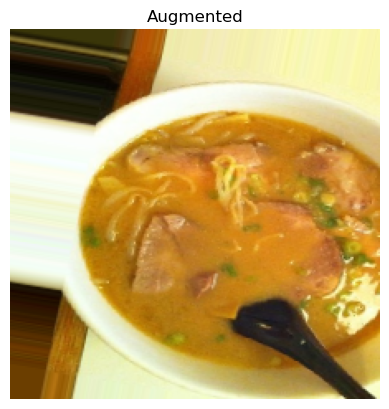

In [48]:
random_number = random.randint(0, batchSize - 1) # we're making batches of size 32, so we'll get a random instance

# 
# Show original image and augmented image
# 
# plt.imshow(images[random_number])
# plt.title(f"Original")
# plt.axis(False)
# plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented")
plt.axis(False);

### Build Model
This is the same as the "baseline", but with augmented data instead of the starting data

In [49]:
# 
# Create
# 
# based on the TinyVGG model
# https://github.com/poloclub/cnn-explainer/blob/master/tiny-vgg/tiny-vgg.py#L179
augmentedModel = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(outputUnitCount, activation='softmax')
])

In [50]:

# 
# Compile
# 
augmentedModel.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [51]:
# 
# FIT
# 
augmentedModelHistory = augmentedModel.fit(train_data_augmented,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=testing_data,
                        validation_steps=len(testing_data))

Epoch 1/5
235/235 [==============================] - 274s 1s/step - loss: 2.2156 - accuracy: 0.1787 - val_loss: 2.0878 - val_accuracy: 0.2240
Epoch 2/5
235/235 [==============================] - 248s 1s/step - loss: 2.1275 - accuracy: 0.2248 - val_loss: 2.0144 - val_accuracy: 0.2792
Epoch 3/5
235/235 [==============================] - 276s 1s/step - loss: 2.0529 - accuracy: 0.2689 - val_loss: 1.9133 - val_accuracy: 0.3264
Epoch 4/5
235/235 [==============================] - 321s 1s/step - loss: 2.0188 - accuracy: 0.2804 - val_loss: 1.8686 - val_accuracy: 0.3268
Epoch 5/5
235/235 [==============================] - 318s 1s/step - loss: 1.9591 - accuracy: 0.3125 - val_loss: 1.7919 - val_accuracy: 0.3744


### Inspect Results
#### Summary

In [52]:
augmentedModel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_8 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 110, 110, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_10 (Conv2D)          (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                 

#### Visualize loss & Accuracy

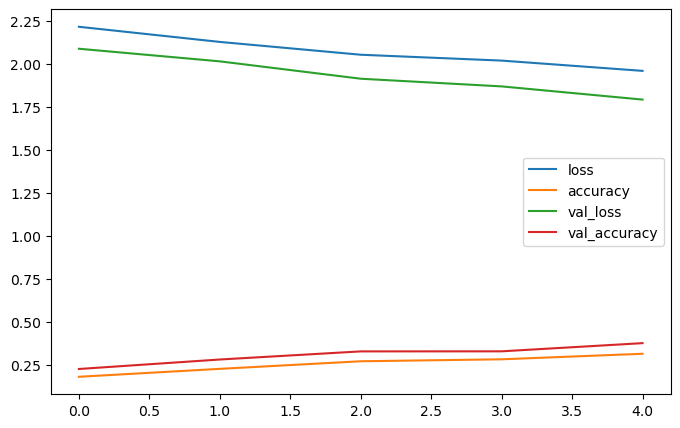

In [53]:
pd.DataFrame(augmentedModelHistory.history).plot(figsize=(8, 5));

Trying adding more epochs to the third augmented model?!

## Updating Fit on Model III: More Epochs, augmentedData

In [69]:
# 
# FIT
# 
# Interesting detail here, calling fit() on the same augmentedModel for the 4th model history here...
augmentedLongerModelHistory = augmentedModel.fit(train_data_augmented,
                                                 epochs=7,
                                                 steps_per_epoch=len(train_data_augmented),
                                                 validation_data=testing_data,
                                                 validation_steps=len(testing_data))

Epoch 1/7
235/235 [==============================] - 268s 1s/step - loss: 1.9248 - accuracy: 0.3277 - val_loss: 1.7718 - val_accuracy: 0.3796
Epoch 2/7
235/235 [==============================] - 303s 1s/step - loss: 1.8737 - accuracy: 0.3521 - val_loss: 1.6899 - val_accuracy: 0.4280
Epoch 3/7
235/235 [==============================] - 256s 1s/step - loss: 1.8570 - accuracy: 0.3587 - val_loss: 1.6836 - val_accuracy: 0.4324
Epoch 4/7
235/235 [==============================] - 241s 1s/step - loss: 1.8263 - accuracy: 0.3737 - val_loss: 1.6186 - val_accuracy: 0.4544
Epoch 5/7
235/235 [==============================] - 289s 1s/step - loss: 1.8127 - accuracy: 0.3705 - val_loss: 1.6114 - val_accuracy: 0.4372
Epoch 6/7
235/235 [==============================] - 248s 1s/step - loss: 1.8000 - accuracy: 0.3779 - val_loss: 1.6539 - val_accuracy: 0.4312
Epoch 7/7
235/235 [==============================] - 218s 927ms/step - loss: 1.7847 - accuracy: 0.3825 - val_loss: 1.6033 - val_accuracy: 0.4632


### Inspect Results

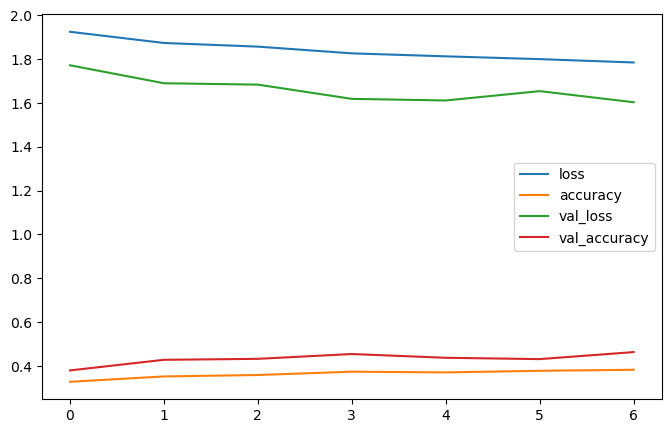

In [71]:
pd.DataFrame(augmentedLongerModelHistory.history).plot(figsize=(8, 5));

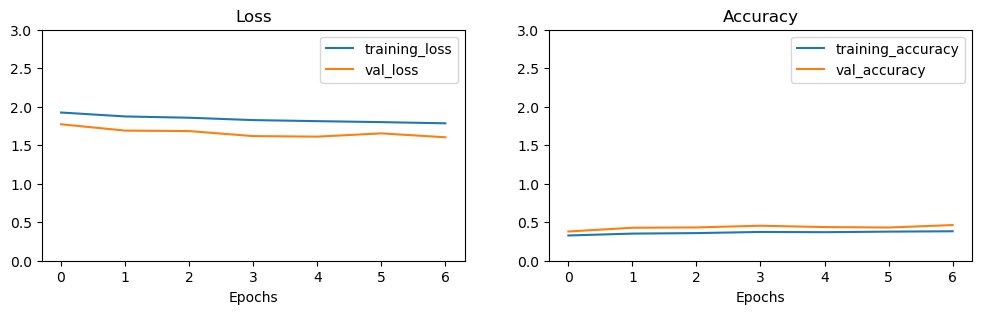

In [75]:
plot_loss_curves(augmentedLongerModelHistory)

## Comparing 4 models
### validation accuracy
- I baseline:          `28%`
- II changing layers:  `34%`
- III augmented data:  `37%`
- IV: augmented-longer:`46%`

### Curves
- I: BAD - loss curve look terrible, and the validation-accuracy goes DOWN
- II: BAD - loss curve looks bad (not as bad as I) and validation-acc stays stagnant
- III: not so bad!

### Re-Fitting same model
`fit()` was called on the same `augmentedModel` for the 3rd and 4th model fitting.  
I believe this made the "overall" model training accuracy higher, rather than starting from "scratch" with the 4th model

### Refitting model AGAIN

In [73]:
# 
# FIT
# 
# Interesting detail here, calling fit() on the same augmentedModel for the 4th model history here...
thirdCallHistory = augmentedModel.fit(train_data_augmented,
                                                 epochs=7,
                                                 steps_per_epoch=len(train_data_augmented),
                                                 validation_data=testing_data,
                                                 validation_steps=len(testing_data))

Epoch 1/7
235/235 [==============================] - 268s 1s/step - loss: 1.7678 - accuracy: 0.3943 - val_loss: 1.6291 - val_accuracy: 0.4472
Epoch 2/7
235/235 [==============================] - 271s 1s/step - loss: 1.7440 - accuracy: 0.4052 - val_loss: 1.5696 - val_accuracy: 0.4680
Epoch 3/7
235/235 [==============================] - 308s 1s/step - loss: 1.7435 - accuracy: 0.3985 - val_loss: 1.5821 - val_accuracy: 0.4660
Epoch 4/7
235/235 [==============================] - 168s 711ms/step - loss: 1.7422 - accuracy: 0.4023 - val_loss: 1.5856 - val_accuracy: 0.4764
Epoch 5/7
235/235 [==============================] - 174s 741ms/step - loss: 1.7116 - accuracy: 0.4163 - val_loss: 1.5420 - val_accuracy: 0.4820
Epoch 6/7
235/235 [==============================] - 168s 713ms/step - loss: 1.7068 - accuracy: 0.4225 - val_loss: 1.5097 - val_accuracy: 0.5056
Epoch 7/7
235/235 [==============================] - 167s 710ms/step - loss: 1.6882 - accuracy: 0.4268 - val_loss: 1.5910 - val_accuracy: 0

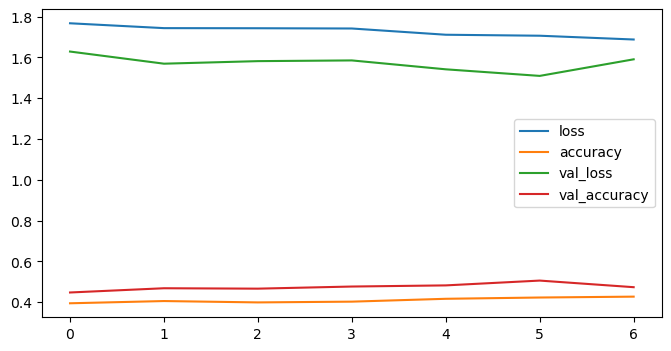

In [77]:
pd.DataFrame(thirdCallHistory.history).plot(figsize=(8, 4));

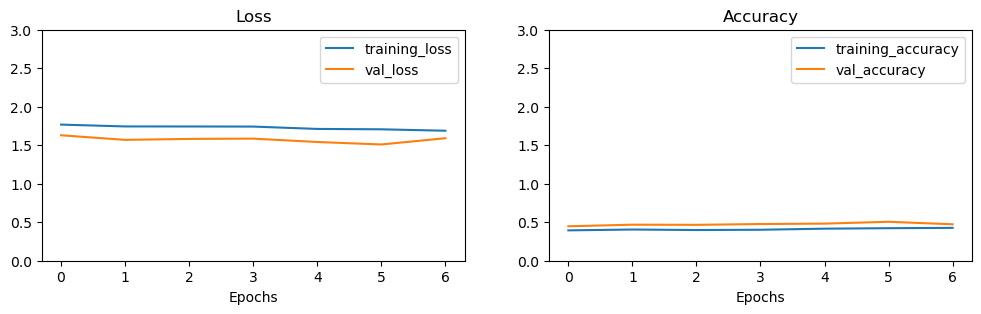

In [78]:
plot_loss_curves(thirdCallHistory)

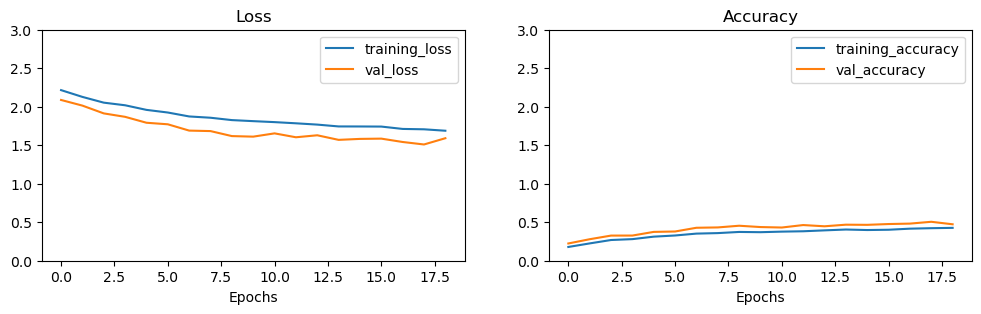

In [92]:
# loss = history.history['loss']
#   val_loss = history.history['val_loss']

#   accuracy = history.history['accuracy']
#   val_accuracy = history.history['val_accuracy']

#   epochCount = range(len(history.history['loss']))

# augmentedModelHistory
# # augmentedLongerModelHistory
# thirdCallHistory
mergedValLoss = augmentedModelHistory.history['val_loss'] + augmentedLongerModelHistory.history['val_loss'] + thirdCallHistory.history['val_loss']
mergedAcc = augmentedModelHistory.history['accuracy'] + augmentedLongerModelHistory.history['accuracy'] + thirdCallHistory.history['accuracy']
mergedValAcc = augmentedModelHistory.history['val_accuracy'] + augmentedLongerModelHistory.history['val_accuracy'] + thirdCallHistory.history['val_accuracy']
mergedLoss = augmentedModelHistory.history['loss'] + augmentedLongerModelHistory.history['loss'] + thirdCallHistory.history['loss']

mergedHistory = {
    'history': {
        'loss': mergedLoss,
        'val_loss': mergedValLoss,
        'accuracy': mergedAcc,
        'val_accuracy': mergedValAcc
    }
}
# mergedHistory.history
plot_loss_curves(mergedHistory)

## Predict New Images With The model

In [94]:
# download imags
# -q is for "quiet"
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-hamburger.jpeg
!wget -q https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-sushi.jpeg

In [105]:
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [106]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

1/1 [==============================] - 0s 36ms/step


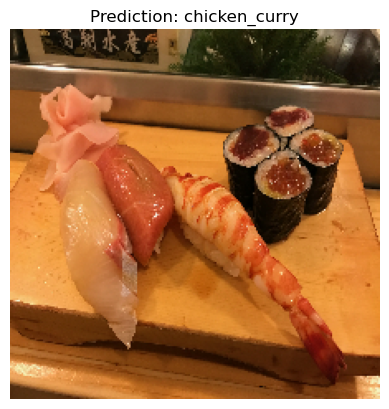

In [107]:
pred_and_plot(augmentedModel, "03-sushi.jpeg", class_names)

1/1 [==============================] - 0s 19ms/step


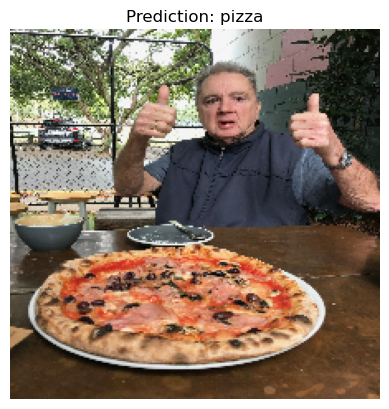

In [108]:
pred_and_plot(augmentedModel, "03-pizza-dad.jpeg", class_names)

1/1 [==============================] - 0s 22ms/step


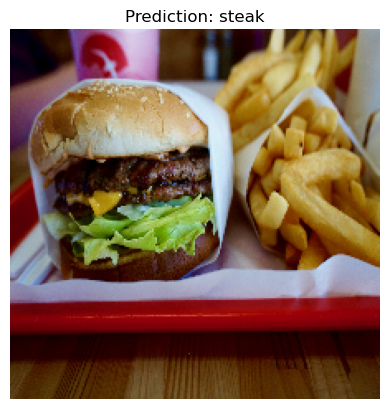

In [109]:
pred_and_plot(augmentedModel, "03-hamburger.jpeg", class_names)

In [ ]:
## Saving The Model
# augmentedModel.save("low_prediction_food_recognition")

# loading the model
# loaded_model_11 = tf.keras.models.load_model("saved_trained_model")
# loaded_model_11.evaluate(test_data)